# Building a handwritten digit recognition system using MNIST dataset

---




## Problem


Handwritten digit recognition is a common problem in a field of Optical Character Recognition `(OCR)`, and it has many practical applications, such as digitizing documents, automating data entry, or processing handwritten forms, such as invoices or surveys. In this project, we will develop a system that can recognize handwritten digits from images or digits written on a screen by using machine learning technology. This system can be extended to perform some basic calculations based on the recognized digits.
The aim of this project are:
- Build a system that can accurately recognize handwritten digits `(0–9)` from input images.
- Convert handwritten input into machine-readable format and perform basic calculations on them such as: addition, subtraction, multiplication and division.

---

## Some main tasks:
- `Data colection`: In this project, you use the MNIST dataset, which consists of 60,000 training images and 10,000 testing images of handwritten digits. Each image is 28x28 pixels and labeled with the correct digit.
- `Image Preprocessing`: Normalize the image data (e.g., convert pixel values to a scale from 0 to 1), resize all images to the same dimensions, and apply noise reduction to improve recognition accuracy.
- `Model Development`: We will study how to build and train a model using an advanced technique that separates different classes of digits in machine learning which is `Support Vector Machine (SVM)` algorithm.
- `Evaluation`: Test the model’s performance using the test dataset and assess its accuracy using metrics like accuracy, precision, recall, and F1 score.
- `Application`: Implement a user interface where users can upload or draw digits on screen, and the system will return the predicted digit based on the trained model. Your system should also be able to work with basic calculations.

# 📚 | Importing libraries

In [30]:
import os

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Processing data
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# library for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Load model
from Model.SVM import SVC

# Load datasets
from tensorflow.keras import datasets

# library for data evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
import cv2

# 📖 | Meta Data
`MNIST dataset`: This is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images. More info can be found at the [MNIST homepage](https://yann.lecun.com/exdb/mnist).

In [2]:
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [5]:
df_symboils = pd.read_csv('./dataset/symbols_dataset_new.csv')
df_symboils.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,+
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,+
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,+
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,+
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,+


# 📊 | Data preprocessing

In [6]:
X_train_flatten = X_train.astype('float32') / 255
X_test_flatten = X_test.astype('float32') / 255

In [7]:
X_train_resize = X_train_flatten.reshape(-1, 28 * 28)
X_test_resize = X_test_flatten.reshape(-1, 28 * 28)

print(X_train_resize.shape, X_test_resize.shape)

(60000, 784) (10000, 784)


In [8]:
df_X_train = pd.DataFrame(X_train_resize)
df_X_test = pd.DataFrame(X_test_resize)
df_y_train = pd.DataFrame(y_train)
df_y_test = pd.DataFrame(y_test)

df_X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df_y_train = df_y_train.rename(columns = {0: 'label'})

In [10]:
df_digit = pd.concat([df_X_train, df_y_train], axis = 1)
df_digit.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


In [11]:
new_column_names = ['pixel' + str(i) for i in range(784)] + ['label']
df_digit.columns = new_column_names
df_digit.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


## 📊 | Processing Data Symbols

In [12]:
df_symboils.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5276 entries, 0 to 5275
Columns: 785 entries, pixel_0 to label
dtypes: float64(784), object(1)
memory usage: 31.6+ MB


In [14]:
df_symboils.columns = new_column_names
df_symboils.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,+
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,+
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,+
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,+
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,+


In [15]:
df_concat = pd.concat([df_digit, df_symboils])
df_concat = df_concat.reset_index(drop = True)

df_concat.tail()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,label
65271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,*
65272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,*
65273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,*
65274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,*
65275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,*


In [16]:
# Assuming that the label for the symbols are as follows:
label_mapping = {'+': 10, '-': 11, '*': 12, '/': 13}

# Replace label in the 'label' column using the mapping
df_concat['label'] = df_concat['label'].replace(label_mapping)

# Now your Dataframe has labels 10, 11, 12, 13 for +, -, *, / respectively
df_concat.tail()

C:\Users\Admin\AppData\Local\Temp\ipykernel_11320\2649524846.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_concat['label'] = df_concat['label'].replace(label_mapping)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,label
65271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
65272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
65273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
65274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
65275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12


In [17]:
X = df_concat.drop(columns = 'label')
y = df_concat['label']

X.shape, y.shape

((65276, 784), (65276,))

In [24]:
# Imblearn dataset
smote = SMOTE(random_state = 42)
X_smote, y_smote = smote.fit_resample(X, y)

print(y.value_counts())
print(y_smote.value_counts())

label
1     6742
7     6265
3     6131
2     5958
9     5949
0     5923
6     5918
8     5851
4     5842
5     5421
10    1500
11    1500
13    1500
12     776
Name: count, dtype: int64
label
5     6742
0     6742
4     6742
1     6742
9     6742
2     6742
3     6742
6     6742
7     6742
8     6742
10    6742
11    6742
13    6742
12    6742
Name: count, dtype: int64


# 🪄 | Data visualization

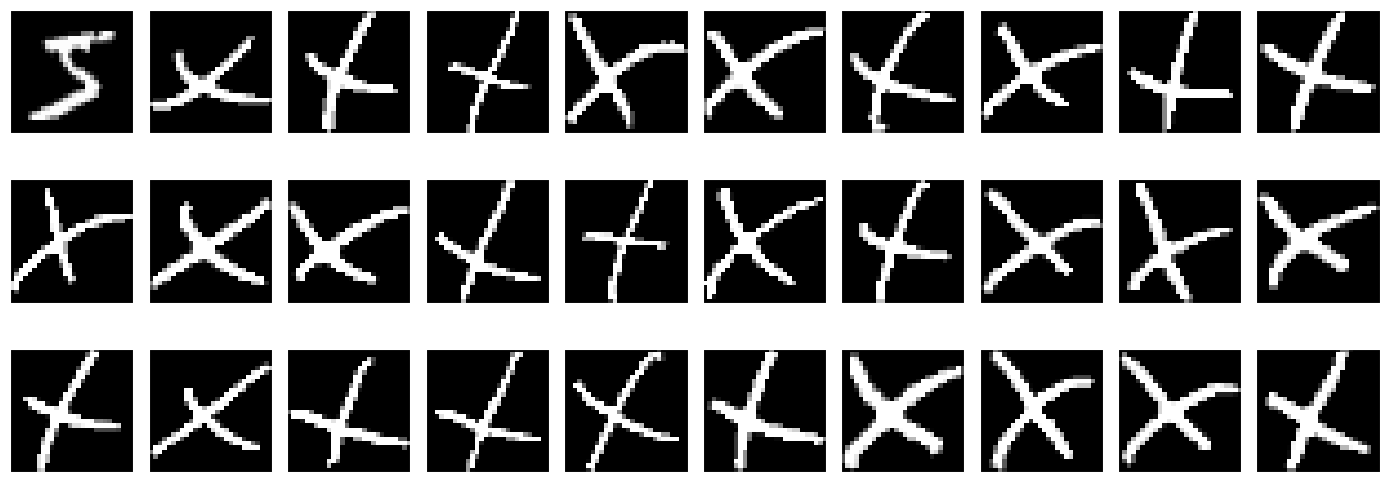

In [20]:
# Visualizing the digits and symbols
plt.figure(figsize = (14, 12))
for digit_image in range(0, 30):
    plt.subplot(7, 10, digit_image + 1)
    grid_data = X.iloc[-digit_image].values.reshape(28, 28)
    plt.imshow(grid_data, interpolation = 'None', cmap = 'gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_11320\29231992.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = y, palette = 'Set1')


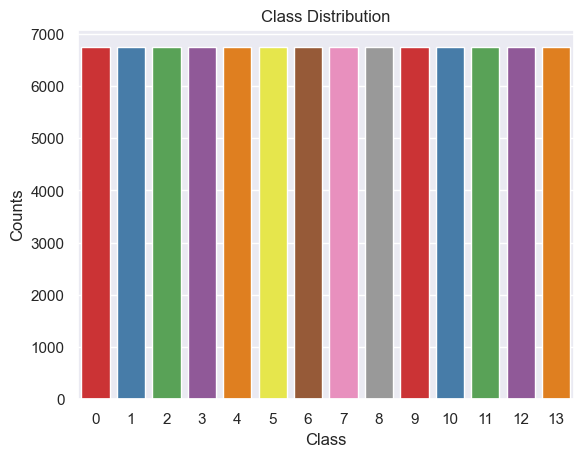

In [38]:
# Visualizing the number of class and counts in the datasets
def class_distribution(y):
    sns.countplot(x = y, palette = 'Set1')
    plt.xlabel('Class')
    plt.ylabel('Counts')
    plt.title('Class Distribution')
    plt.show()


class_distribution(y_smote)

# ☣ | Building model SVM

In [35]:
#Splitting the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size = 0.2, random_state = 42)

# Print the shape of the data
print(f'X_train = {X_train.shape}, y_train = {y_train.shape}, X_test = {X_test.shape}, y_test = {y_test.shape}')

X_train = (75510, 784), y_train = (75510,), X_test = (18878, 784), y_test = (18878,)


C:\Users\Admin\AppData\Local\Temp\ipykernel_11320\29231992.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = y, palette = 'Set1')


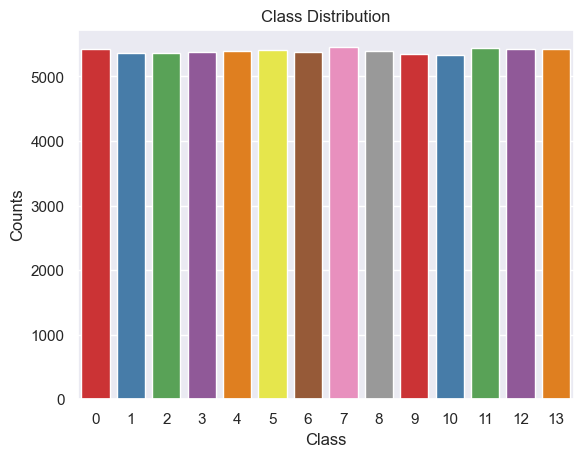

In [39]:
# Visualizing the number of class and counts in the datasets
class_distribution(y_train)

C:\Users\Admin\AppData\Local\Temp\ipykernel_11320\29231992.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = y, palette = 'Set1')


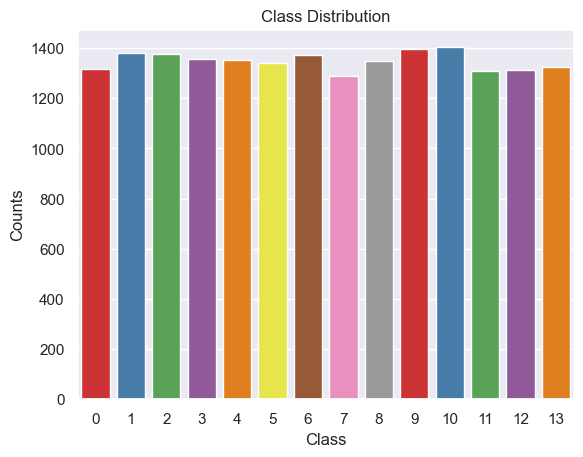

In [40]:
# Visualizing the number of class and counts in the datasets
class_distribution(y_test)

In [42]:
# Convert the data into numpy arrays
X_train_array = X_train.to_numpy()
y_train_array = y_train.to_numpy()
X_test_array = X_test.to_numpy()
y_test_array = y_test.to_numpy()

# Print the shape of the data
X_train_array[:5], y_train_array[:5]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([6, 9, 2, 9, 3], dtype=int64))

In [43]:
# Create the model
# The model is created with the following hyperparameters:
# Learning rate = 0.001
# Number of iterations = 100
# Lambda parameter = 0.0001
# The model is trained on the training data
svc = SVC(learning_rate = 0.001, no_of_iterations = 100, lambda_parameter = 0.0001)

# Fit the model
svc.fit(X_train_array, y_train_array)

In [44]:
# Predict the model
y_predict = svc.predict(X_test_array)

# Print the predicted values
print(f'Predict values: {y_predict[:5]}')

# Print the actual values
print(f'Actual values: {y_test_array[:5]}')

Predict values: [ 3  5 11  4  5]
Actual values: [ 3  5 11  2  5]


# 📊 | Model evaluation

In [46]:
# Calculate the accuracy of the model
test_accuracy = accuracy_score(y_test_array, y_predict)
print(f'Test Accuracy: {test_accuracy * 100:.3f}%')

Test Accuracy: 93.898%


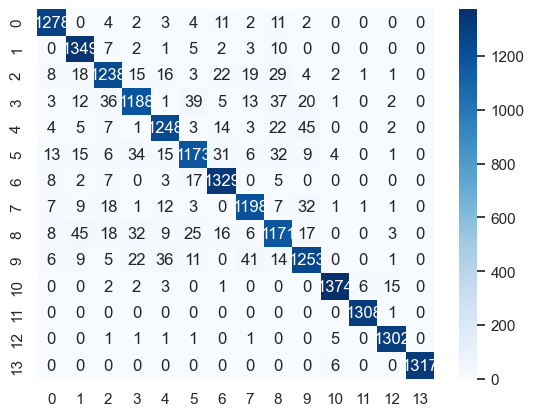

In [47]:
# Confusion matrix
confusion = confusion_matrix(y_test_array, y_predict)

# Plot the confusion matrix
sns.heatmap(confusion, annot = True, fmt = 'd', cmap = 'Blues')
plt.show()

In [48]:
# Classification report
class_wine = classification_report(y_test_array, y_predict)
print(class_wine)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1317
           1       0.92      0.98      0.95      1379
           2       0.92      0.90      0.91      1376
           3       0.91      0.88      0.89      1357
           4       0.93      0.92      0.92      1354
           5       0.91      0.88      0.89      1339
           6       0.93      0.97      0.95      1371
           7       0.93      0.93      0.93      1290
           8       0.88      0.87      0.87      1350
           9       0.91      0.90      0.90      1398
          10       0.99      0.98      0.98      1403
          11       0.99      1.00      1.00      1309
          12       0.98      0.99      0.99      1312
          13       1.00      1.00      1.00      1323

    accuracy                           0.94     18878
   macro avg       0.94      0.94      0.94     18878
weighted avg       0.94      0.94      0.94     18878



# 📸 | Predicting the image

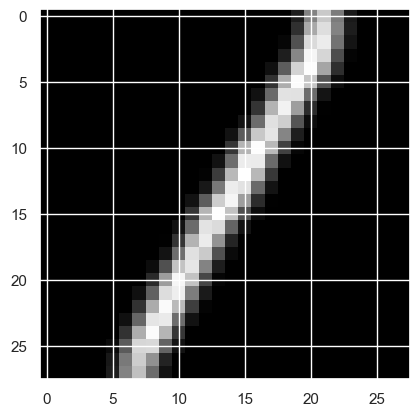

[13]


In [56]:
image = cv2.imread('D:\Graduation_Project\dataset\symbols\slash-0201.png')

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

blurred_image = cv2.GaussianBlur(gray_image, (3, 3), 0)

resize_image = cv2.resize(blurred_image, (28, 28))

plt.imshow(resize_image, cmap = 'gray')
plt.show()

flatten_image = resize_image.astype('float32') / 255
flatten_image = flatten_image.reshape(1, -1)

prediction = svc.predict(flatten_image)
print(prediction)

# 💾 | Save the model

In [57]:
joblib.dump(svc, r"D:\\Graduation_Project\\Model\\svm_digit_classifier_version2.pkl")

['D:\\\\Graduation_Project\\\\Model\\\\svm_digit_classifier_version2.pkl']